# Long Short Term Memory (LSTM) - Overcoming limitations of RNN


### Readings

http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf - Hochreiter's original paper on LSTM

http://arxiv.org/pdf/1410.4615.pdf - Sutskever SOTA LSTM - Feb 2015

http://arxiv.org/pdf/1506.00019v4.pdf - Lipton's excellent survey of RNN

https://www.youtube.com/watch?v=izGl1YSH_JA - Hinton video on LSTM



## LSTM background

http://arxiv.org/pdf/1506.00019v4.pdf - architecture of LSTM

https://www.youtube.com/watch?v=izGl1YSH_JA - Hinton video gives clear animation of signal coming into LSTM, waiting in LSTM until useful, gradient calculation and signal leaving LSTM.  Anyone bring popcorn?

LSTM was invented by Hochreiter to overcome some of the issues with conventional RNN's.  The forget gate was introduced by Gers et. al.  Code for LSTM is below.  

In [1]:
#based on  code from https://gist.github.com/tmramalho/5e8fda10f99233b2370f
import theano
import theano.tensor as T
import numpy as np
import cPickle as pickle
import random
import matplotlib.pyplot as plt
from itertools import izip
%matplotlib inline

In [22]:
class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        # cell input
        W_ug = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hg = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        b_g = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # input gate equation
        W_ui = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hi = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_i = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # forget gate equations
        W_uf = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hf = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_f = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # cell output gate equations
        W_uo = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_ho = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_o = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # output layer
        W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)

        # cell input
        W_ug = theano.shared(W_ug, 'W_ug')
        W_hg = theano.shared(W_hg, 'W_hg')
        b_g = theano.shared(b_g, 'b_g')
        # input gate equation
        W_ui = theano.shared(W_ui, 'W_ui')
        W_hi = theano.shared(W_hi, 'W_hi')
        b_i = theano.shared(b_i, 'b_i')
        # forget gate equations
        W_uf = theano.shared(W_uf, 'W_uf')
        W_hf = theano.shared(W_hf, 'W_hf')
        b_f = theano.shared(b_f, 'b_f')
        # cell output gate equations
        W_uo = theano.shared(W_uo, 'W_uo')
        W_ho = theano.shared(W_ho, 'W_ho')
        b_o = theano.shared(b_o, 'b_o')
        # output layer
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hy = theano.shared(b_hy, 'b_hy')

        self.activ1 = T.nnet.sigmoid
        self.activ2 = T.tanh
        
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()


        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        s0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))


        #theano.printing.debugprint([h0_tm1, u, W_hh, W_uh, W_hy, b_hh, b_hy], print_type=True)
        [h, s], _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1, s0_tm1],
                           non_sequences = [W_ug, W_hg, b_g, W_ui, W_hi,
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy])

        y = T.dot(h[-1], W_hy) + b_hy
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_ug, gW_hg, gb_g, gW_ui, gW_hi, gb_i, \
        gW_uf, gW_hf, gb_f, gW_uo, gW_ho, gb_o, gW_hy, gb_hy \
            = T.grad(cost, [W_ug, W_hg, b_g, W_ui, W_hi, b_i, \
            W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy])
            
        update = [(W_ug, W_ug - lr*gW_ug), 
                  (W_hg, W_hg - lr*gW_hg ), 
                  (b_g, b_g - lr*gb_g), 
                  (W_ui, W_ui - lr*gW_ui),
                  (W_hi, W_hi - lr*gW_hi), 
                  (b_i, b_i - lr*gb_i), 
                  (W_uf, W_uf - lr*gW_uf), 
                  (W_hf, W_hf - lr*gW_hf),
                  (b_f, b_f - lr*gb_f),
                  (W_uo, W_uo - lr*gW_uo), 
                  (W_ho, W_ho - lr*gW_ho), 
                  (b_o, b_o - lr*gb_o),
                  (W_hy, W_hy - lr*gW_hy), 
                  (b_hy, b_hy - lr*gb_hy)]
        
        #theano.printing.debugprint([h0_tm1], print_type=True)
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=update,
            allow_input_downcast=True)
        
        
                
        self.predict_step = theano.function([u, t], cost,
           on_unused_input='warn',
           allow_input_downcast=True)
        

    def recurrent_fn(self, u_t, h_tm1, s_tm1, W_ug, W_hg, b_g, W_ui, W_hi,
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy):
        g_t = self.activ2(T.dot(u_t, W_ug) + T.dot(h_tm1, W_hg) + b_g)
        i_t = self.activ1(T.dot(u_t, W_ui) + T.dot(h_tm1, W_hi) + b_i)
        f_t = self.activ1(T.dot(u_t, W_uf) + T.dot(h_tm1, W_hf) + b_f)
        o_t = self.activ1(T.dot(u_t, W_uo) + T.dot(h_tm1, W_ho) + b_o)
        s_t = g_t * i_t + s_tm1*f_t
        h_t = self.activ2(s_t)*o_t
        
        #h_t = self.activ2(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return [h_t, s_t]

In [2]:
(xlist, ylist) = pickle.load(open('stockTT.bin', 'rb'))
nInputs = len(xlist[0])
x = np.array(xlist, dtype = theano.config.floatX)
y = np.array(ylist, dtype = theano.config.floatX)

In [23]:
nHidden = 20
nOutputs = 1
rnn = RNN(nInputs, nHidden, nOutputs)

In [17]:
lr = 0.01
e = 1.0
nPasses = 1
vals = [] 

In [26]:
# run model
train_mse = []
test_mse = []
train_length = int(len(x) * 0.8)
test_length = len(x) - train_length
for i in range(nPasses):
    # train weights
    for j in xrange(train_length):
        u = np.asarray(xlist[j], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[j]
        
        c = rnn.train_step(u, t, lr)
        if j%200==0: print "train iteration {0}: {1}".format(j, np.sqrt(c))
        e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        train_mse.append(np.sqrt(c))
                   
    # make predictions                       
    for k in xrange(train_length,len(x)):
        u = np.asarray(xlist[k], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[k]

        c = rnn.predict_step(u, t)
        if k%200==0: print "test iteration {0}: {1}".format(k - train_length, np.sqrt(c))
        #e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        test_mse.append(np.sqrt(c))

train iteration 0: 0.870665775953
train iteration 200: 0.122261982784
train iteration 400: 2.9393555349
train iteration 600: 3.04606071309
train iteration 800: 2.99885092753
train iteration 1000: 0.256862316415
train iteration 1200: 0.918914829659
train iteration 1400: 0.772946626322
train iteration 1600: 0.616126532697
train iteration 1800: 0.200537697382
train iteration 2000: 0.212814463965
train iteration 2200: 1.22106003581
train iteration 2400: 0.552616622684
train iteration 2600: 0.551956887433
test iteration 44: 1.27406577595
test iteration 244: 0.832834224047
test iteration 444: 4.07993422405
test iteration 644: 1.51633422405


In [27]:
print "train error {}".format(np.mean(train_mse))
print "test error {}".format(np.mean(test_mse))

train error 1.24968266264
test error 1.43396332708


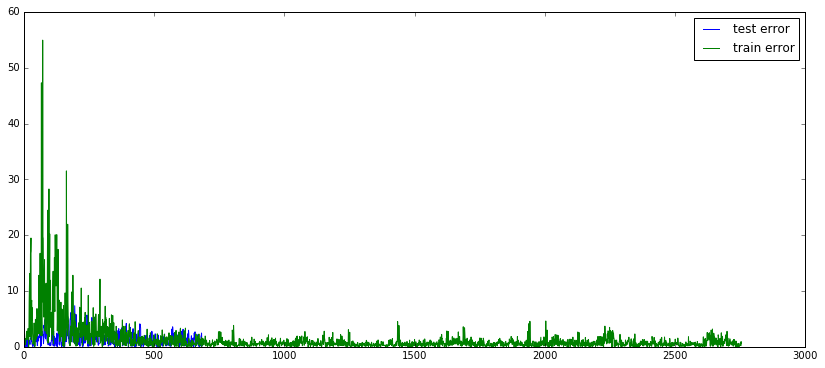

In [28]:
plt.figure(figsize = (14,6))
plt.plot(test_mse, label = "test error")
plt.plot(train_mse, label = "train error")
plt.legend()
plt.show()

### Q's
1.  Make parametric changes to LSTM and see how performance changes. 
2.  Add "peephole" connection mentioned in Lipton

#### 1.  Make parametric changes to LSTM and see how performance changes. 

In [70]:
nHidden = 20 # increase number of hidden nodes 20 --> 100
nOutputs = 1
rnn = RNN(nInputs, nHidden, nOutputs)

In [71]:
lr = 0.001
e = 1.0
nPasses = 1

In [72]:
# run model
train_mse_h = []
test_mse_h = []
train_length = int(len(x) * 0.8)
test_length = len(x) - train_length
for i in range(nPasses):
    # train weights
    for j in xrange(train_length):
        u = np.asarray(xlist[j], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[j]
        
        c = rnn.train_step(u, t, lr)
        if j%200==0: print "train iteration {0}: {1}".format(j, np.sqrt(c))
        #e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        train_mse_h.append(np.sqrt(c))
                   
    # make predictions                       
    for k in xrange(train_length,len(x)):
        u = np.asarray(xlist[k], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[k]

        c = rnn.predict_step(u, t)
        if k%200==0: print "test iteration {0}: {1}".format(k - train_length, np.sqrt(c))
        #e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        test_mse_h.append(np.sqrt(c))

train iteration 0: 1.27395111455
train iteration 200: 4.64426812733
train iteration 400: 4.87307903011
train iteration 600: 1.48564697427
train iteration 800: 3.33310481091
train iteration 1000: 0.524721442891
train iteration 1200: 0.602715636987
train iteration 1400: 0.645676918676
train iteration 1600: 1.19555392539
train iteration 1800: 0.621014439222
train iteration 2000: 2.16546465862
train iteration 2200: 0.828576175891
train iteration 2400: 0.996606788177
train iteration 2600: 0.279571467713
test iteration 44: 1.49264952847
test iteration 244: 0.614250471525
test iteration 444: 3.86135047153
test iteration 644: 1.29775047153


In [73]:
print "train error {}".format(np.mean(train_mse_h))
print "test error {}".format(np.mean(test_mse_h))

train error 1.75193876893
test error 1.42273464588


Turn nest the parameter matricies into a list, each index representing a different cell

In [78]:
class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        
        # Initalize Parameters for 1st cell
        rng = np.random.RandomState(1234)
        # cell input
        W_ug = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hg = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        b_g = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # input gate equation
        W_ui = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hi = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_i = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # forget gate equations
        W_uf = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hf = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_f = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # cell output gate equations
        W_uo = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_ho = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_o = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # output layer
        #W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        #b_hy = np.zeros((nout,), dtype=theano.config.floatX)
        
        # Initalize Parameters for 2st cell
        rng = np.random.RandomState(6673)
        # cell input
        W_ug_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hg_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        b_g_2 = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # input gate equation
        W_ui_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hi_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_i_2 = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # forget gate equations
        W_uf_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hf_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_f_2 = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # cell output gate equations
        W_uo_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_ho_2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_o_2 = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # output layer
        W_hy_2 = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hy_2 = np.zeros((nout,), dtype=theano.config.floatX)        
        


        
        # Parameters for 1st cell
        # cell input
        W_ug = theano.shared(W_ug, 'W_ug')
        W_hg = theano.shared(W_hg, 'W_hg')
        b_g = theano.shared(b_g, 'b_g')
        # input gate equation
        W_ui = theano.shared(W_ui, 'W_ui')
        W_hi = theano.shared(W_hi, 'W_hi')
        b_i = theano.shared(b_i, 'b_i')
        # forget gate equations
        W_uf = theano.shared(W_uf, 'W_uf')
        W_hf = theano.shared(W_hf, 'W_hf')
        b_f = theano.shared(b_f, 'b_f')
        # cell output gate equations
        W_uo = theano.shared(W_uo, 'W_uo')
        W_ho = theano.shared(W_ho, 'W_ho')
        b_o = theano.shared(b_o, 'b_o')
        # output layer
        #W_hy = theano.shared(W_hy, 'W_hy')
        #b_hy = theano.shared(b_hy, 'b_hy')
        
        
        # Parameters for 2st cell
        # cell input
        W_ug_2 = theano.shared(W_ug_2, 'W_ug_2')
        W_hg_2 = theano.shared(W_hg_2, 'W_hg_2')
        b_g_2 = theano.shared(b_g_2, 'b_g_2')
        # input gate equation
        W_ui_2 = theano.shared(W_ui_2, 'W_ui_2')
        W_hi_2 = theano.shared(W_hi_2, 'W_hi_2')
        b_i_2 = theano.shared(b_i_2, 'b_i_2')
        # forget gate equations
        W_uf_2 = theano.shared(W_uf_2, 'W_uf_2')
        W_hf_2 = theano.shared(W_hf_2, 'W_hf_2')
        b_f_2 = theano.shared(b_f_2, 'b_f_2')
        # cell output gate equations
        W_uo_2 = theano.shared(W_uo_2, 'W_uo_2')
        W_ho_2 = theano.shared(W_ho_2, 'W_ho_2')
        b_o_2 = theano.shared(b_o_2, 'b_o_2')
        # output layer
        W_hy_2 = theano.shared(W_hy_2, 'W_hy_2')
        b_hy_2 = theano.shared(b_hy_2, 'b_hy_2')        
        


        self.activ1 = T.nnet.sigmoid
        self.activ2 = T.tanh
        
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()


        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        s0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        h_tm1_2 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        s_tm1_2 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))


        #theano.printing.debugprint([h0_tm1, u, W_hh, W_uh, W_hy, b_hh, b_hy], print_type=True)
        [ h,s,h1,s1],_ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1, s0_tm1,h_tm1_2, s_tm1_2], 
                           non_sequences = [W_ug, W_hg, b_g, W_ui, W_hi,\
                                            b_i, W_uf, W_hf, b_f, W_uo, \
                                            W_ho, b_o,\
                                            W_ug_2, W_hg_2, b_g_2, W_ui_2, W_hi_2,\
                                            b_i_2, W_uf_2, W_hf_2, b_f_2, W_uo_2, \
                                            W_ho_2, b_o_2, W_hy_2, b_hy_2])

        y = T.dot(h[-1], W_hy_2) + b_hy_2
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_ug, gW_hg, gb_g, gW_ui, gW_hi, gb_i, \
        gW_uf, gW_hf, gb_f, gW_uo, gW_ho, gb_o, \
        gW_ug_2, gW_hg_2, gb_g_2, gW_ui_2, gW_hi_2, gb_i_2, \
        gW_uf_2, gW_hf_2, gb_f_2, gW_uo_2, gW_ho_2, gb_o_2, \
        gW_hy_2, gb_hy_2 \
            = T.grad(cost, [W_ug, W_hg, b_g, W_ui, W_hi, b_i, \
                            W_uf, W_hf, b_f, W_uo, W_ho, b_o,\
                           W_ug_2, W_hg_2, b_g_2, W_ui_2, W_hi_2, b_i_2, \
                            W_uf_2, W_hf_2, b_f_2, W_uo_2, W_ho_2, b_o_2, W_hy_2, b_hy_2])
            
        update = [(W_ug, W_ug - lr*gW_ug), 
                  (W_hg, W_hg - lr*gW_hg ), 
                  (b_g, b_g - lr*gb_g), 
                  (W_ui, W_ui - lr*gW_ui),
                  (W_hi, W_hi - lr*gW_hi), 
                  (b_i, b_i - lr*gb_i), 
                  (W_uf, W_uf - lr*gW_uf), 
                  (W_hf, W_hf - lr*gW_hf),
                  (b_f, b_f - lr*gb_f), 
                  (W_uo, W_uo - lr*gW_uo), 
                  (W_ho, W_ho - lr*gW_ho), 
                  (b_o, b_o - lr*gb_o),
                  #(W_hy, W_hy - lr*gW_hy), 
                  #(b_hy, b_hy - lr*gb_hy),
                 
                 (W_ug_2, W_ug_2 - lr*gW_ug_2), 
                  (W_hg_2, W_hg_2 - lr*gW_hg_2 ), 
                  (b_g_2, b_g_2 - lr*gb_g_2), 
                  (W_ui_2, W_ui_2 - lr*gW_ui_2),
                  (W_hi_2, W_hi_2 - lr*gW_hi_2), 
                  (b_i_2, b_i_2 - lr*gb_i_2), 
                  (W_uf_2, W_uf_2 - lr*gW_uf_2), 
                  (W_hf_2, W_hf_2 - lr*gW_hf_2),
                  (b_f_2, b_f_2 - lr*gb_f_2), 
                  (W_uo_2, W_uo_2 - lr*gW_uo_2), 
                  (W_ho_2, W_ho_2 - lr*gW_ho_2), 
                  (b_o_2, b_o_2 - lr*gb_o_2),
                  (W_hy_2, W_hy_2 - lr*gW_hy_2), 
                  (b_hy_2, b_hy_2 - lr*gb_hy_2)
                 ]
        
        #theano.printing.debugprint([h0_tm1], print_type=True)
        
        # Train
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=update,
            allow_input_downcast=True)
        
        
        # Predict      
        self.predict_step = theano.function([u, t], cost,
           on_unused_input='warn',
           allow_input_downcast=True)
        

    def recurrent_fn(self, u_t, h_tm1, s_tm1, h_tm1_2, s_tm1_2,W_ug, W_hg, b_g, W_ui, W_hi,
                           b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, 
                     
                                 W_ug_2, W_hg_2, b_g_2, W_ui_2, W_hi_2,
                           b_i_2, W_uf_2, W_hf_2, b_f_2, W_uo_2, W_ho_2, b_o_2, W_hy_2, b_hy_2):

        # 1st cell 
        g_t = self.activ2(T.dot(u_t, W_ug) + T.dot(h_tm1, W_hg) + b_g)
        i_t = self.activ1(T.dot(u_t, W_ui) + T.dot(h_tm1, W_hi) + b_i)
        f_t = self.activ1(T.dot(u_t, W_uf) + T.dot(h_tm1, W_hf) + b_f)
        o_t = self.activ1(T.dot(u_t, W_uo) + T.dot(h_tm1, W_ho) + b_o)
        s_t = g_t * i_t + s_tm1*f_t
        h_t = self.activ2(s_t)*o_t
        
        
        # 2nd cell
        # ouput of 1st cell, h_t, is the input of the 2nd cell
        g_t_2 = self.activ2(T.dot(h_t, W_ug_2) + T.dot(h_tm1_2, W_hg_2) + b_g_2)
        i_t_2 = self.activ1(T.dot(h_t, W_ui_2) + T.dot(h_tm1_2, W_hi_2) + b_i_2)
        f_t_2 = self.activ1(T.dot(h_t, W_uf_2) + T.dot(h_tm1_2, W_hf_2) + b_f_2)
        o_t_2 = self.activ1(T.dot(h_t, W_uo_2) + T.dot(h_tm1_2, W_ho_2) + b_o_2)
        s_t_2 = g_t_2 * i_t_2 + s_tm1_2*f_t_2
        h_t_2 = self.activ2(s_t_2)*o_t_2
        
        #h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return [h_t_2,s_t_2,h_t,s_t]

In [79]:
nHidden = 20
nOutputs = 1
rnn = RNN(nInputs, nHidden, nOutputs)

In [80]:
# run model
train_mse = []
test_mse = []
train_length = int(len(x) * 0.8)
test_length = len(x) - train_length
lr = 1e-1
e = 1.0
nPasses = 1

In [81]:
# run model
for i in range(nPasses):
    # train weights
    for j in xrange(train_length):
        u = np.asarray(xlist[j], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[j]
        
        c = rnn.train_step(u, t, lr)
        if j%200==0: print "train iteration {0}: {1}".format(j, np.sqrt(c))
        e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        train_mse.append(np.sqrt(c))
                   
    # make predictions                       
    for k in xrange(train_length,len(x)):
        u = np.asarray(xlist[k], dtype = theano.config.floatX).reshape((1,nInputs))
        t = y[k]

        c = rnn.predict_step(u, t)
        if k%200==0: print "test iteration {0}: {1}".format(k - train_length, np.sqrt(c))
        #e = 0.1*np.sqrt(c) + 0.9*e
        # for taining modification, do not smooth the error
        test_mse.append(np.sqrt(c))

train iteration 0: 1.27996425235
train iteration 200: 4.24800313233
train iteration 400: 5.08333125116
train iteration 600: 1.77125189481
train iteration 800: 3.42133843836
train iteration 1000: 0.325689251337
train iteration 1200: 0.859534416952
train iteration 1400: 0.772966004118
train iteration 1600: 1.2439123503
train iteration 1800: 0.560396685469
train iteration 2000: 1.99870700687
train iteration 2200: 0.862844691794
train iteration 2400: 1.24175198779
train iteration 2600: 0.444249814864
test iteration 44: 1.29207126239
test iteration 244: 0.814828737607
test iteration 444: 4.06192873761
test iteration 644: 1.49832873761


# Change LSMT for Character Prediction

### How to change the above code in order to incorporate the LSTM model
    1. change dim output layer
    2. change output layer act func to softmax for classification
    3. change loss to cross-entropy

In [74]:
class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        # cell input
        W_ug = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hg = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        b_g = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # input gate equation
        W_ui = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hi = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_i = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # forget gate equations
        W_uf = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hf = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_f = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # cell output gate equations
        W_uo = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_ho = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_o = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # output layer
        W_hy = np.asarray(rng.normal(size=(n_hidden,nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)

        # cell input
        W_ug = theano.shared(W_ug, 'W_ug')
        W_hg = theano.shared(W_hg, 'W_hg')
        b_g = theano.shared(b_g, 'b_g')
        # input gate equation
        W_ui = theano.shared(W_ui, 'W_ui')
        W_hi = theano.shared(W_hi, 'W_hi')
        b_i = theano.shared(b_i, 'b_i')
        # forget gate equations
        W_uf = theano.shared(W_uf, 'W_uf')
        W_hf = theano.shared(W_hf, 'W_hf')
        b_f = theano.shared(b_f, 'b_f')
        # cell output gate equations
        W_uo = theano.shared(W_uo, 'W_uo')
        W_ho = theano.shared(W_ho, 'W_ho')
        b_o = theano.shared(b_o, 'b_o')
        # output layer
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hy = theano.shared(b_hy, 'b_hy')

        self.activ1 = T.nnet.sigmoid
        self.activ2 = T.tanh
        self.activ_out = T.nnet.softmax
        
        lr = T.scalar()
        u = T.matrix()
        t = T.matrix()
        y = T.matrix()


        h0_tm1 = theano.shared(np.ones((1, n_hidden), dtype=theano.config.floatX))
        s0_tm1 = theano.shared(np.ones((1, n_hidden), dtype=theano.config.floatX))


        #theano.printing.debugprint([u,h0_tm1, s0_tm1, W_ug, W_hg, b_g, \
        #W_ui, W_hi, b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy], print_type=True)
        
        [h,s], _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1, s0_tm1],
                           non_sequences = [W_ug, W_hg, b_g, W_ui, W_hi,\
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o,b_hy])
        
        
        
        #theano.printing.debugprint([h,W_hy], print_type=True)
        out_arg = T.dot(h[-1], W_hy) + b_hy # h is storing all prior predictions
                                            # so we only reference the lastest 
        
        y = self.activ_out(out_arg)
        
        # rank error !
        #theano.printing.debugprint([t,y,b_hy,W_hy], print_type=True)
        #cost = T.mean(T.nnet.categorical_crossentropy(t,y)) # change positions of args due to log(0) error!
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_ug, gW_hg, gb_g, gW_ui, gW_hi, gb_i, \
        gW_uf, gW_hf, gb_f, gW_uo, gW_ho, gb_o, gW_hy, gb_hy \
            = T.grad(cost, [W_ug, W_hg, b_g, W_ui, W_hi, b_i, \
            W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy])
            
        update = [(W_ug, W_ug - lr*gW_ug), 
                  (W_hg, W_hg - lr*gW_hg ), 
                  (b_g, b_g - lr*gb_g), 
                  (W_ui, W_ui - lr*gW_ui),
                  (W_hi, W_hi - lr*gW_hi), 
                  (b_i, b_i - lr*gb_i), 
                  (W_uf, W_uf - lr*gW_uf), 
                  (W_hf, W_hf - lr*gW_hf),
                  (b_f, b_f - lr*gb_f),
                  (W_uo, W_uo - lr*gW_uo), 
                  (W_ho, W_ho - lr*gW_ho), 
                  (b_o, b_o - lr*gb_o),
                  (W_hy, W_hy - lr*gW_hy), 
                  (b_hy, b_hy - lr*gb_hy)]
        
        theano.printing.debugprint([h0_tm1], print_type=True)
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=update,
            allow_input_downcast=True)
        
        
                
        self.predict_step = theano.function([u, t], cost,
           on_unused_input='warn',
           allow_input_downcast=True)
        

    def recurrent_fn(self, u_t, h_tm1, s_tm1, W_ug, W_hg, b_g, W_ui, W_hi,
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, b_hy):
        
        g_t = self.activ2(T.dot(u_t, W_ug) + T.dot(h_tm1, W_hg) + b_g)
        i_t = self.activ1(T.dot(u_t, W_ui) + T.dot(h_tm1, W_hi) + b_i)
        f_t = self.activ1(T.dot(u_t, W_uf) + T.dot(h_tm1, W_hf) + b_f)
        o_t = self.activ1(T.dot(u_t, W_uo) + T.dot(h_tm1, W_ho) + b_o)
        
        s_t = g_t * i_t + s_tm1*f_t
        h_t = self.activ2(s_t)*o_t
    
        #h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return [h_t,s_t]

In [8]:
# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 30088 characters, 58 unique.


In [10]:
# iterate through data
p = 0 
# limit 'ch' to 1 character
seq_length = len(data) - 1
inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
targets = [char_to_ix[ch]  for ch in data[p+1:p+seq_length+1]]

In [75]:
# change dim of output layer, done!
nHidden = 20
nOutputs = len(chars)
nInputs = len(chars)
rnn = RNN(nInputs, nHidden, nOutputs)

<TensorType(float64, matrix)> [@A] <TensorType(float64, matrix)>


In [79]:
# create labels with one-hot encoding
u = []
t = []
train_mse = []
test_mse = []
lr = 0.000001
count = 0 
for i,o in  izip(inputs,targets):   
    u = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    u[inputs[i]] = 1 # one-hot encoding
    u = u.T
    
    t = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    t[inputs[o]] = 1 # one-hot encoding
    t = t.T
    
    c = rnn.train_step(u, t, lr)
    train_mse.append(np.sqrt(c))
    
    c = rnn.predict_step(u, t)
    test_mse.append(np.sqrt(c))
    count += 1
    
    if count == 3:
        break
    